In [1]:
import numpy as np
import fenics as fe
fe.set_log_level(40)

from tqdm.notebook import tqdm_notebook

In [2]:
## Define heat conductivity $\lambda (\alpha)$ [W/(m K)]
def lambda_concrete(vf_aggr, vf_paste, alpha):
    """
    heat conductivity of concrete via multiscale homogenization [W/(m K)]
    """
    lambda_aggr= 3.0 # https://doi.org/10.1016/j.jrmge.2021.08.008 from graph for sand at zero porosity
    lambda_paste= 1.0

    lambda_ini_concrete_lower= lambda_paste + vf_aggr / (1/(lambda_aggr-lambda_paste) + vf_paste/(3*lambda_paste))
    lambda_ini_concrete_upper= lambda_aggr + vf_paste / (1/(lambda_paste-lambda_aggr) + vf_aggr/(3*lambda_aggr))
    lambda_ini_concrete_mean= (lambda_ini_concrete_lower+lambda_ini_concrete_upper)/2.

    lambda_concrete_sealed= lambda_ini_concrete_mean*(1+0.22*alpha)
    return lambda_concrete_sealed


## Define specific heat capacity $c(\alpha)$ [J/(kg K)]
def c_concrete(wcr, mf_aggr, mf_paste, alpha):
    """
    Specific heat capacity of concrete via multiscale homogenization [J/(kg K)]
    """
    c_water= 4180 # [J/(kg K)]
    c_cement= 750
    c_aggr= 800 # 10.13140/RG.2.1.1045.0403

    c_paste= (c_water*wcr+c_cement)/(1+wcr)*(1-0.26*(1-fe.exp(-2.9*alpha))) # assuming sealed conditions
    c_concrete= mf_aggr*c_aggr + mf_paste*c_paste
    return c_concrete


## Define affinity-based hydration model [1/s]
def evalChemAffinity(alpha):
    """
    Evaluate chemical affinity-based hydration model.
    Model parameters must be calibrated using isothermal calorimetry for each cement paste individually prior usage.
    """

    ## Calibration parameters of affinity-based hydration model for CEM I Ladce, 391 m^2/kg, wcr=0.35
    B1= 0.000176001
    B2= 0.0019201
    eta= 6.91838
    alpha_infty=0.35/0.42

    if alpha==0:
        Atld_ref=0
    else:
        Atld_ref= B1*(B2/alpha_infty+alpha)*(alpha_infty-alpha)*fe.exp(-eta*alpha/alpha_infty)

    return Atld_ref


## Define scaling parameter $\beta_T$ for temperature [$-$]
def betaT(T):
    """
    Evaluate scaling parameter from temperature fluctuation
    """
    Ea= 38300 # [J/mol], apparent activation energy
    R= 8.31441 # [J/(mol*K)], universal gas constant
    Tref= 293.15 # [K] = 20 C, reference temperature for which Atld_ref is measured

    betaT= fe.exp(Ea/R*(1/Tref-1/(T+273.15)))

    return betaT


## Define scaling parameter $\beta_H$ for humidity [$-$]
def betaH(H):
    """
    Evaluate scaling parameter from humidity fluctuation
    """
    a= 7.5 # [-] from [Bazant1972]
    betaH= 1./(1.+(a-a*H)**4.)
    return betaH



## Alternate diffusion coefficient $D_H$ [m/s^2] from [Bazant:1972]
def diffusivityBazant(H):
    """
    evaluates the diffusivity from [Bazant:1972]

    Parameters
    ----------
    H : float
        relative humidity [-].

    Returns
    -------
    DH
    """
#     ## fib MC 2010 recomendation (also in [Oliveira:2015]):
#     fcm= 30 # [MPa]; estimated compressive strength of concrete
#     DH1= (1e-8)/(fcm-8) # = 4.5454e-10 m^2/s for fc=30; =39.3 mm^2/day
#     gamma= 0.05; Hc= 0.75; n= 12

    ##[Havlasek:2016]:
#     DH1= 2.8935e-10 # [m^2/s]; =25 mm^2/day => 25/8.64e+10 
#     gamma= 0.1; Hc= 0.8; n= 10 

    ##[Sovjak:2018]:
    #DH1= 4.6296e-10 # [m^2/s]; =40 mm^2/day => 40/8.64e+10
    #gamma= 0.05; Hc=0.75; n= 12

    DH1= 200/8.64e+10 # [m^2/s]
    gamma= 0.05 # 0.05 
    Hc=0.75 # 0.75 
    n= 12 # 12

    return DH1 * (gamma + (1-gamma)/(1+( (1-H)/(1-Hc) )**n))


## Hygrothermic coefficient [1/K] from [Bazant:1972]
def heat_rate(T_new, T_old, dt):
    return (T_new-T_old)/dt

def HTcoef(H_new):
    return 0.0135*H_new*(1-H_new)/(1.25-H_new)

In [3]:
width= 0.16
height= 0.02
thick= 0.04 # [m]; out-of-plane dimension, default= 1 m for extruded structures
Tini= 21
T_remote= 21
# heatFlowSides= 2
H_remote= 0.60
# humFlowSides= 1.0e-7

## Mix design - mass of constituent to create a 1 m^3 of concrete
wcr= 0.35
m_cement= 500 # [kg/m^3]
m_water= wcr*m_cement # [kg/m^3]
m_fineAggr= 1300 # [kg/m^3]
m_coarseAggr= m_fineAggr/3. # [kg/m^3]

rho_cement= 3140 # [kg/m^3] (estimated)
rho_water= 1000 # [kg/m^3] (estimated)
rho_aggr= 2600 # [kg/m^3] (estimated)


## Thermal characteristic of cement used
Qpotential= 532000 # potential heat of hydration in [J/kg]; =530 J/g for goldenDefault

Hini= 1.0 # [-]; initial RH throughout the cross-section

## Time evaluation
total_time= 10*60 # [s]; target time
dt= 1

In [4]:
## Mesh discretization
numElemW= 1000
numElemH= numElemW * height/width

mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(width, height), nx=int(numElemW), ny=int(numElemH), diagonal="right")

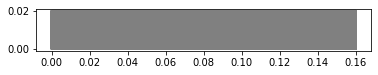

In [5]:
fe.plot(mesh)

In [6]:
quadrature_rules={'quadrature_degree' : 1, 'quadrature_scheme' : 'default'}

In [7]:
element_family = 'CG'

element = fe.FiniteElement(element_family, mesh.ufl_cell(),
                               degree=quadrature_rules.get('quadrature_degree'),
                               quad_scheme=quadrature_rules.get('quadrature_scheme'))
mixed_element = fe.MixedElement([element,]*3)

W = fe.FunctionSpace(mesh, mixed_element)

u_ = fe.TestFunctions(W)

δu = fe.TrialFunction(W)

u_new = fe.Function(W)

u_old = fe.Function(W)

dx = fe.dx(metadata={'quadrature_degree': quadrature_rules['quadrature_degree']})

In [8]:
## Calculate mix proportions
rho_concrete= m_cement+m_water+m_fineAggr+m_coarseAggr # density of 1 m^3 of concrete

# Mix-related proportions of constituents: mf_* mass fraction; vf_* volume fraction
wcr= m_water/m_cement # water-to-cement mass ratio
mf_paste= (m_cement+m_water)/(m_cement+m_water+m_fineAggr+m_coarseAggr)
mf_aggr= (m_fineAggr+m_coarseAggr)/(m_cement+m_water+m_fineAggr+m_coarseAggr)

vf_paste= (m_cement/rho_cement+m_water/rho_water)/(m_cement/rho_cement+m_water/rho_water+m_fineAggr/rho_aggr+m_coarseAggr/rho_aggr)
vf_aggr= (m_fineAggr/rho_aggr+m_coarseAggr/rho_aggr)/(m_cement/rho_cement+m_water/rho_water+m_fineAggr/rho_aggr+m_coarseAggr/rho_aggr)


# Calculate dimension of the mesh
dim= mesh.topology().dim()

# Define boundary on mesh
surface_dim= dim - 1
boundaries= fe.MeshFunction("size_t", mesh, surface_dim)

# setting tags for all boundaries as 99
boundaries.set_all(99)

## Define INITIAL CONDITION
element_space = fe.FunctionSpace(mesh, element)

s = fe.Function(element_space)

s.interpolate(fe.Constant(Tini))
fe.assign(u_old.sub(0), s)

s.interpolate(fe.Constant(Hini)) # discretize the IC onto the function space - translate to the nodal values on function space on this mesh
fe.assign(u_old.sub(1), s)

## Boundary conditions
"""
mark BC ID as follows:

#3#
0 1
#2#

""" 
#### MARK BOUNDARIES:
left= fe.CompiledSubDomain("near(x[0], 0) && on_boundary")
left.mark(boundaries, 0)
# bc_left= fe.DirichletBC(W, fe.Constant((20.0)), left)

# right= fe.CompiledSubDomain("near(x[0], 0.10) && on_boundary")
right= fe.CompiledSubDomain("near(x[0], %.3f) && on_boundary" %(width))
right.mark(boundaries, 1)

bottom = fe.CompiledSubDomain("near(0, x[1]) && on_boundary")
bottom.mark(boundaries, 2)

# top= fe.CompiledSubDomain("near(0.50, x[1]) && on_boundary")
top= fe.CompiledSubDomain("near(%.3f, x[1]) && on_boundary" %(height))
top.mark(boundaries, 3)


#### ASSIGN BC FOR TEMPERATURE:
hT= [2, 2, 2, 9] 
boundary_conditions_T= {0: {'Robin':     (hT[0], T_remote)}, #0: {'Dirichlet': fe.Constant(20.0)}
                        1: {'Robin':     (hT[1], T_remote)},
                        2: {'Robin':     (hT[2], T_remote)},
                        3: {'Robin':     (hT[3], T_remote)} }

#### Collect DIRICHLET BC:
bcs = []
for i in boundary_conditions_T:
    if 'Dirichlet' in boundary_conditions_T[i]:
        bcT= fe.DirichletBC(W.sub(0), boundary_conditions_T[i]['Dirichlet'], boundaries, i)
        bcs.append(bcT)

#### Collect ROBIN BC:
ds = fe.Measure('ds', domain=mesh, subdomain_data=boundaries)   
integrals_R_a_T = []
integrals_R_L_T = []
for i in boundary_conditions_T:
    if 'Robin' in boundary_conditions_T[i]:
        r, s = boundary_conditions_T[i]['Robin']
        integrals_R_a_T.append(r*u_new[0]*u_[0]*ds(i))
        integrals_R_L_T.append(r*s*u_[0]*ds(i))


#### ASSIGN BC FOR HUMIDITY :
hW= [1.157407e-10, 1.157407e-10, 1.157407e-10, 1e-7] 
boundary_conditions_H = {0: {'Robin':     (hW[0], H_remote)}, #0: {'Dirichlet': fe.Constant(0.98)}
                         1: {'Robin':     (hW[1], H_remote)},
                         2: {'Robin':     (hW[2], H_remote)},
                         3: {'Robin':     (hW[3], H_remote)} }

#### Collect DIRICHLET BC:

for i in boundary_conditions_H:
    if 'Dirichlet' in boundary_conditions_H[i]:
        bcH= fe.DirichletBC(W.sub(1), boundary_conditions_H[i]['Dirichlet'], boundaries, i)
        bcs.append(bcH)


#### Collect ROBIN BC:
integrals_R_a_H = []
integrals_R_L_H = []
for i in boundary_conditions_H:
    if 'Robin' in boundary_conditions_H[i]:
        r1, s1 = boundary_conditions_H[i]['Robin']
        integrals_R_a_H.append(r1*u_new[1]*u_[1]*ds(i))
        integrals_R_L_H.append(r1*s1*u_[1]*ds(i))


## Solution parameters
num_steps= int((total_time / dt) + 1) # number of time steps +1 at end to reach exact time

snes_solver_parameters = {"nonlinear_solver": "newton",
                      "newton_solver": {"linear_solver": "gmres",
                                        "preconditioner" :'ilu',
                                        "maximum_iterations": 100000,
                                        "report": False,
                                        "absolute_tolerance":1e-10,
                                        "relative_tolerance":1e-10,
                                        "error_on_nonconvergence": True}}


## Solve coupled problem
## Starting values
t= fe.Constant(0) # [sec] keep track of elapsed time, should be equal throughout cross-section

alpha= fe.Constant(0) # [-]
dalpha= 1e-7 # constant increment of alpha for numerical integration of time

max_T= Tini
min_H= Hini

Qtot= Qpotential*m_cement*thick # total stored heat in assumed sample


def Qdot(alpha, T, H):
    return Qtot * evalChemAffinity(alpha) * betaT(T) * betaH(H)

def dwhdt(alpha, T, H):
    return 0.23*m_cement*width*height*thick*evalChemAffinity(alpha) * betaT(T) * betaH(H) # evaluate water consumed by hydration

def DH(H):
    return diffusivityBazant(H)


# weak form for temperature
var = rho_concrete*c_concrete(wcr, mf_aggr, mf_paste, u_new[2])*u_new[0]*u_[0]*dx \
    + dt*lambda_concrete(vf_aggr, vf_paste, u_new[2])*fe.dot(fe.grad(u_new[0]), fe.grad(u_[0]))*dx \
    + dt*sum(integrals_R_a_T) \
    - rho_concrete*c_concrete(wcr, mf_aggr, mf_paste, u_new[2])*u_old[0]*u_[0]*dx \
    - dt*Qdot(u_new[2], u_new[0], u_new[1])*u_[0]*dx \
    - dt*sum(integrals_R_L_T)

k= fe.Constant(320)

# weak form for humidity
var += u_new[1]*u_[1]*dx \
    + dt*DH(u_new[1])*fe.dot(fe.grad(u_new[1]), fe.grad(u_[1]))*dx \
    + dt*sum(integrals_R_a_H) \
    + (dt/k)*dwhdt(u_new[2], u_new[0], u_new[1])*u_[1]*dx \
    - dt*HTcoef(u_new[1])*heat_rate(u_new[0], u_old[0], dt)*u_[1]*dx \
    - u_old[1]*u_[1]*dx \
    - dt*sum(integrals_R_L_H)

# weak form for affinity
var += u_new[2]*u_[2]*dx \
    - u_old[2]*u_[2]*dx \
    - dt*evalChemAffinity(u_new[2]) * betaT(u_new[0]) * betaH(u_new[1]) *u_[2]*dx \
    

# solve variational problem
problem = fe.NonlinearVariationalProblem(var, u_new, bcs, fe.derivative(var, u_new, δu))

solver= fe.NonlinearVariationalSolver(problem)
solver.parameters.update(snes_solver_parameters)

In [9]:
save_dataTXT= 1
if save_dataTXT:
    expTXTfile= "MMdata_v8_validation_Keita2019_humidityCJ.txt"
    fout= open(expTXTfile, 'w')


######################################################################################################
## SOLVE PROBLEM
splitted_u_old = u_old.split(True)

In [10]:
for s in tqdm_notebook(range(0, num_steps)):
    
    solver.solve()
    u_old.assign(u_new)
    splitted_u_old = u_old.split(True)
        
#     if splitted_u_old[1](width/2., height) <= H_limit:
#         print('threshold limit reached at time ', s*dt)
#         break
#     print(s*dt, splitted_u_old[1](width/2., height))

    if save_dataTXT:
        fout.write('%i\t%.4f\n' 
                   %(s*dt,
                     splitted_u_old[1](width/2., height)))

    

In [11]:
print(s*dt, splitted_u_old[1](width/2., height))

600 0.9780093332293575


In [12]:
if save_dataTXT:
    fout.close()

In [13]:
import matplotlib.pyplot as plt

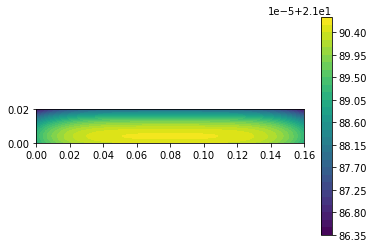

In [14]:
cb = fe.plot(splitted_u_old[0])
plt.colorbar(cb)

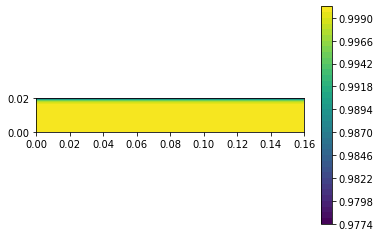

In [15]:
cb = fe.plot(splitted_u_old[1])
plt.colorbar(cb)

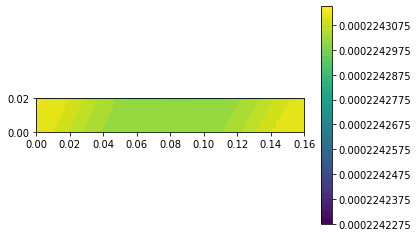

In [17]:
cb = fe.plot(splitted_u_old[2])
plt.colorbar(cb)